In [1]:
from pyspark import SparkContext, SparkConf
conf = SparkConf().setMaster("yarn").setAppName("MatrixMultiplication")
conf.set("spark.executor.memory", "4g")
conf.set("spark.driver.memory", "4g")
conf.set("spark.cores.max", "2")
sc = SparkContext(conf=conf)
sc.getConf().getAll()

[('spark.driver.port', '36571'),
 ('spark.driver.memory', '4g'),
 ('spark.executorEnv.PYTHONPATH',
  '/usr/local/spark/python:<CPS>{{PWD}}/pyspark.zip<CPS>{{PWD}}/py4j-0.10.9-src.zip'),
 ('spark.executor.memory', '4g'),
 ('spark.executor.id', 'driver'),
 ('spark.app.id', 'application_1636170469565_0013'),
 ('spark.executor.heartbeatInterval', '10000000'),
 ('spark.driver.bindAddress', '192.1.1.11'),
 ('spark.app.name', 'MatrixMultiplication'),
 ('spark.ui.port', '4050'),
 ('spark.master', 'yarn'),
 ('spark.driver.appUIAddress', 'http://edge:4050'),
 ('spark.rdd.compress', 'True'),
 ('spark.yarn.jars', ''),
 ('spark.driver.host', 'edge'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.network.timeout', '10000001'),
 ('spark.cores.max', '2'),
 ('spark.submit.pyFiles', ''),
 ('spark.yarn.isPython', 'true'),
 ('spark.app.startTime', '1636189902242'),
 ('spark.submit.deployMode', 'client'),
 ('spark.ui.proxyBase', '/proxy/application_1636170469565_0013'),
 ('spark.org.apache.hadoo

In [2]:
M_RDD = (sc
          .textFile("hdfs://yarnmaster:9000/M_very_small",16))
N_RDD = (sc
          .textFile("hdfs://yarnmaster:9000/N_very_small",16))

I tried to run a tiny file first to test the algorithm.

I also tested on different number of partitions and found 8 is the best one

In [3]:
def convertToFloat(x):
    for i in range (len(x[0])):
        x[0][i] = (x[1],i,float(x[0][i]))
    return x

In [4]:
M_processed = M_RDD.zipWithIndex().map(lambda x: [x[0].split(),x[1]]).map(convertToFloat) \
.flatMap(lambda x: x[0])
N_processed = N_RDD.zipWithIndex().map(lambda x: [x[0].split(),x[1]]).map(convertToFloat) \
.flatMap(lambda x: x[0])
M_processed_2 = M_processed.map(lambda x: (x[1],(x[0], x[2])))
N_processed_2 = N_processed.map(lambda x: (x[0],(x[1], x[2])))

The code above is for parsing matrix from text file.
+ zipWithIndex => add row index
+ convertToFloat => add col index and matrix value at (row,col)
+ The map of M_processed_2 and N_processed_2 is to convert to desired format. Because the 'M', 'N' tags are quite useless so I discarded them.

In [5]:
len(M_RDD.zipWithIndex().map(lambda x: [x[0].split(),x[1]]).take(1)[0][0])

2000

In [6]:
joinMat = M_processed_2.join(N_processed_2).map(lambda x: x[1]) \
.map(lambda x: ((x[0][0],x[1][0]), x[0][1]*x[1][1]))

Simply join 2 RDD, change the format and do multiplication

In [7]:
import time
s = time.time()
res = joinMat.reduceByKey(lambda x,y: x+y).take(5)
end = time.time()
print("Time processed: ", end-s)
print(res)

Time processed:  1607.380967617035
[((63, 3), 5190132.256200001), ((63, 35), 5055799.594699998), ((63, 67), 5134599.535599999), ((63, 99), 5043296.007900001), ((63, 131), 5127966.3175)]


Do the reduceByKey to get the result.

###PROBLEM WITH THIS CODE:
This code works fine with small matrix, but take very long time to work on larger matrix.
As I inspected, the most time-consuming job is reduceByKey

####THING THAT I HAVE TRIED:
+ Broadcast and join : I got stuck because sc.broadcast return a broadcast variable not rdd
+ Test with different number of partitions: For large file, increase the numbers of partitions helps reduce the time.
+ Group by key on each RDD -> do the join -> use itertools to create the combinations : this approach solve the complexity of join, but the groupByKey is still taking lot of times(I guess) so it's not able to solve the problem.
+ Collect the second rdd into list -> use flatMap in the first RDD to create combinations: This approach is still not able to solve the problem, but I can still reduce number of combinations to get the first few columns
+ Increase spark.executor.memory and spark.driver.memory => almost x2 speed

I tried to run small file with 128 partitions => It would take about 11 hours.
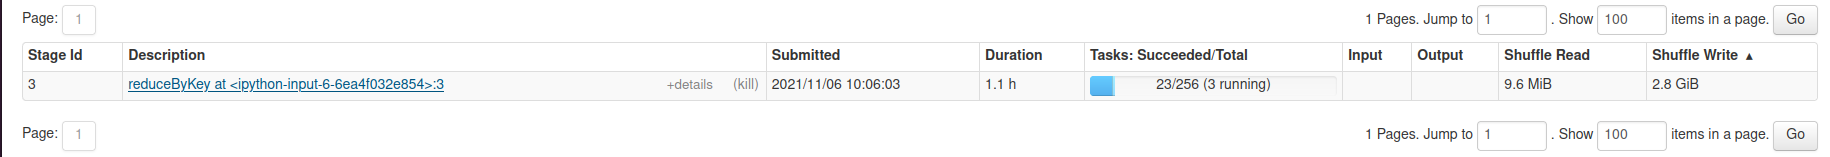

I think I have to do more optimization to make it run faster

In [8]:
#I can get the first few columns by this way
M_RDD = (sc
          .textFile("hdfs://yarnmaster:9000/M_small",16))
N_RDD = (sc
          .textFile("hdfs://yarnmaster:9000/N_small",16))
M_processed = M_RDD.zipWithIndex().map(lambda x: [x[0].split(),x[1]]).map(convertToFloat) \
.flatMap(lambda x: x[0])
N_processed = N_RDD.zipWithIndex().map(lambda x: [x[0].split(),x[1]]).map(convertToFloat) \
.flatMap(lambda x: x[0])
M_processed_2 = M_processed.map(lambda x: (x[1],(x[0], x[2])))
N_processed_2 = N_processed.map(lambda x: (x[0],(x[1], x[2])))
####convert second matrix into list and sort
n_mat = N_processed_2.collect()
n_mat.sort(key=lambda x: x[0])


In [9]:
def combinator(x):
    comb = []
    for i in range (5): #this should set to the number of columns in second matrix => I only try to get first 5 cols
        comb.append(((x[0],i), x[1], x[2]))
    return comb

In [10]:
M_combinator = M_processed.flatMap(combinator).cache()
M_combinator.take(5)

[((0, 0), 0, 73.75),
 ((0, 1), 0, 73.75),
 ((0, 2), 0, 73.75),
 ((0, 3), 0, 73.75),
 ((0, 4), 0, 73.75)]

((0, 0), 0, 73.75) -> this means: (i=0,k=0) j=0 Mij = 73.75. (Mij and Njk)

In [11]:
import time
s = time.time()
res = M_combinator.map(lambda x: (x[0], x[2]*n_mat[x[0][0]*2000+x[1]][1][1])).reduceByKey(lambda x,y: x+y) \
.take(5)
end = time.time()
print("Time processed: ", end-s)
print(res)

Time processed:  100.4994421005249
[((292, 2), 5109748.704399996), ((298, 0), 4939570.7046000045), ((191, 3), 5084266.203700014), ((271, 3), 5148655.394800012), ((261, 1), 4952277.600300004)]


we do simple map and multiply by querying elements from n_mat.
2000 means the number of column in n_mat.
After that we do reduceByKey and get the result. However, this method get the broken pipe error a lot. I still strugle with that.